In [1]:
import Pkg; Pkg.add(["Plots", "Polyhedra", "GLPK"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Project.toml`
  No Changes to `~/srv/rep/22-course-cse6643/mybinder/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; plotlyjs(); default(l=5, size=(900,550), label=false);
using Printf;
using Polyhedra;

import GLPK
lib = DefaultLibrary{Float64}(GLPK.Optimizer)
BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), v)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=:diverging_gwv_55_95_c39_n256
        ; kwargs...
    )
end
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

# Conditioning of Least Squares Problems



## Review

### The least squares problem

> Given $A \in \mathbb{C}^{m \times n}$ of full rank, $m \geq n$, $b \in \mathbb{C}^{m}$,
> find $x \in \mathbb{C}^n$ such that $\| b - A x \|$ is minimized.

($\|\cdot\| = \|\cdot\|_2$ throughout)

In [4]:
plotlyjs();
function plot_ls_diagram(A,b)
    corners = Float64[[-1,-1,-1] [ 1,-1,-1] [-1, 1,-1] [ 1, 1,-1] [-1,-1, 1] [ 1,-1, 1] [-1, 1, 1] [ 1, 1, 1]];
    cycle = [1, 2, 4, 3, 7, 8, 6, 5, 1]
    cube = polyhedron(vrep(corners'), lib)
    triangle = [[2.0, 0.0] [-1.0, sqrt(3.)] [-1.0, -sqrt(3)]]*4
    x = A \ b
    y = A * x
    r = b - y
    r̂ = r / norm(r)
    ŷ = y / norm(y)
    ẑ = r̂ × ŷ
    Q, R = qr(A, ColumnNorm())
    scale = maximum(abs.([b y]))
    if scale == 0
        scale = 1
    end
    scale *= 1.1
    p = plot([0,b[1]], [0,b[2]], [0,b[3]]
        , lim=(-scale, scale)
        , size=(1000,1000)
        , colorbar=:legend
        , c = 1
        , label="b"
        , hover="b:<br>$(@sprintf("%+.2f", b[1]))<br>$(@sprintf("%+.2f", b[2]))<br>$(@sprintf("%+.2f", b[3]))"
    )
    plot!(p, [b[1]], [b[2]], [b[3]]
        , m = :o
        , c = 1
    )
    plot!(p, scale*corners[1,:], scale*corners[2,:], scale*corners[3,:], st=:scatter3d, marker=:cross, markersize=1)
    plot!(p,[0,y[1]], [0,y[2]], [0,y[3]]
        , c = 2
        , label="y = Pb = Ax"
        , hover="x:<br>$(@sprintf("%+.2f", x[1]))<br>$(@sprintf("%+.2f", x[2]))<br>y:<br>$(@sprintf("%+.2f", y[1]))<br>$(@sprintf("%+.2f", y[2]))<br>$(@sprintf("%+.2f", y[3]))"
    )
    plot!(p,[y[1]], [y[2]], [y[3]]
        , c = 2
        , m = :square
    )
    plot!(p,[y[1],b[1]],[y[2],b[2]],[y[3],b[3]]
        , c = 3
        , label="r = b - Ax"
        , hover="r:<br>$(@sprintf("%+.2f", b[1] - y[1]))<br>$(@sprintf("%+.2f", b[2] - y[2]))<br>$(@sprintf("%+.2f", b[3] - y[3]))"
        )
    if (abs(R[1,1]) != 0.0)
        if abs(R[2,2]) > eps() * 100. * abs(R[1,1])
            # plot plane 
            Qtrivert = Q[:,1:2]*triangle
            Qtri = polyhedron(vrep((Q[:,1:2]*triangle)'), lib)
            isect = hcat(points(vrep(intersect(cube, Qtri)))...)*scale
            plot!(p,isect[1,:],isect[2,:],isect[3,:],st=:mesh3d
                , l = 0
                , fillalpha=0.5
                , label="range(A)"
                )
            q1 = A[:,1]
            q1max = maximum(abs.(q1))
            q1 *= scale / q1max
            plot!(p,[-q1[1], q1[1]],[-q1[2],q1[2]],[-q1[3],q1[3]]
                , c = 4
                , label = "a₁"
                , hover="a₁:<br>$(@sprintf("%+.2f", A[1,1]))<br>$(@sprintf("%+.2f", A[2,1]))<br>$(@sprintf("%+.2f", A[3,1]))"
            )
            q2 = A[:,2]
            q2max = maximum(abs.(q2))
            q2 *= scale / q2max
            plot!(p,[-q2[1], q2[1]],[-q2[2],q2[2]],[-q2[3],q2[3]]
                , c = 5
                , label = "a₂"
                , hover="a₂:<br>$(@sprintf("%+.2f", A[1,2]))<br>$(@sprintf("%+.2f", A[2,2]))<br>$(@sprintf("%+.2f", A[3,2]))"
            )
            plot!(p
                , [y[1] - 0.1 * ŷ[1], y[1] - 0.1 * ŷ[1] + 0.1 * r̂[1], y[1] + 0.1*r̂[1]]
                , [y[2] - 0.1 * ŷ[2], y[2] - 0.1 * ŷ[2] + 0.1 * r̂[2], y[2] + 0.1*r̂[2]]
                , [y[3] - 0.1 * ŷ[3], y[3] - 0.1 * ŷ[3] + 0.1 * r̂[3], y[3] + 0.1*r̂[3]]
                , c=:black
                , l=1
            )
            plot!(p
                , [y[1] - 0.1 * ẑ[1], y[1] - 0.1 * ẑ[1] + 0.1 * r̂[1], y[1] + 0.1*r̂[1]]
                , [y[2] - 0.1 * ẑ[2], y[2] - 0.1 * ẑ[2] + 0.1 * r̂[2], y[2] + 0.1*r̂[2]]
                , [y[3] - 0.1 * ẑ[3], y[3] - 0.1 * ẑ[3] + 0.1 * r̂[3], y[3] + 0.1*r̂[3]]
                , c=:black
                , l=1
            )
        else
            # plot line
            q = Q[:,1]
            qmax = maximum(abs.(q))
            q *= scale / qmax
            plot!(p,[-q[1], q[1]],[-q[2],q[2]],[-q[3],q[3]]
            )
        end
    end
    return p
end;

In [5]:
q = plot_ls_diagram(randn(3,2), randn(3))
plot!(q, size=(600,500))

**Problem components:**

- Data $X$?

$$A, b$$

- Solution $Y$?

$$x = A^+ b$$
$$y = Ax = Pb$$

### Spot exercise

Define $A^+$ (a) just using matrix multiplication and inverses, (b) using the SVD.

$$
A^+ = (A^* A)^{-1} A^*
$$

$$A = \hat{U} \hat{\Sigma} V^*$$

$$A^+ = V \hat{\Sigma}^{-1} \hat{U}^*$$

### Spot exercise

Define the projector $P$ onto $\mathrm{range}(A)$ using $A$ and $A^+$.

$$ P = A A^+$$

### Review: relative conditioning

Short mnemonic version:

$$\kappa = \frac{\|\delta f\| / \|f\|}{\|\delta x\| / \|x\|}$$

Full version:

$$\kappa(x) = \lim_{\rho \to 0} \sup_{\|\delta x\| \leq \rho} \frac{\|f(x + \delta x) - f(x)\| / \|f(x)\|}{\|\delta x\| / \|x\|}$$

**Differentiable version:**

$$
\kappa(x) = \frac{\|J(x)\|}{\|f(x)\| / \|x\|}$$

Invertible matrix problems ($A: x \mapsto Ax$, $A: b \mapsto A^{-1}b$, $b: A \mapsto A^{-1}b$):

$$\kappa(A) = \|A\|\|A^{-1}\| = \frac{\sigma_1}{\sigma_m}$$

### Condition number of a full rank matrix $A \in \mathbb{C}^{m \times n}$, $m \geq n$

Keep the SVD definition

$$\kappa(A) = \frac{\sigma_1}{\sigma_n}$$

$$\Leftrightarrow \kappa(A) = \|A\| \|A^+\|$$

## ⚠️ Least squares problem conditioning involves more than just $\kappa(A)$

**Three non-dimensional quantities govern least-squares conditioning**

1. $\kappa(A) = \frac{\sigma_1}{\sigma_n} = \|A\| \|A^+\|, \quad 1 \leq \kappa(A) < \infty$

2. $\theta = \cos^{-1} \frac{\|y\|}{\|b\|}, \quad 0 \leq \theta \leq \pi / 2$

![](./least_squares_angle.svg)

### Which is the "bad" end of the possibilities, $\theta = 0$ or $\theta = \pi/2$? Can we measure its effects on $x$ and $y$?

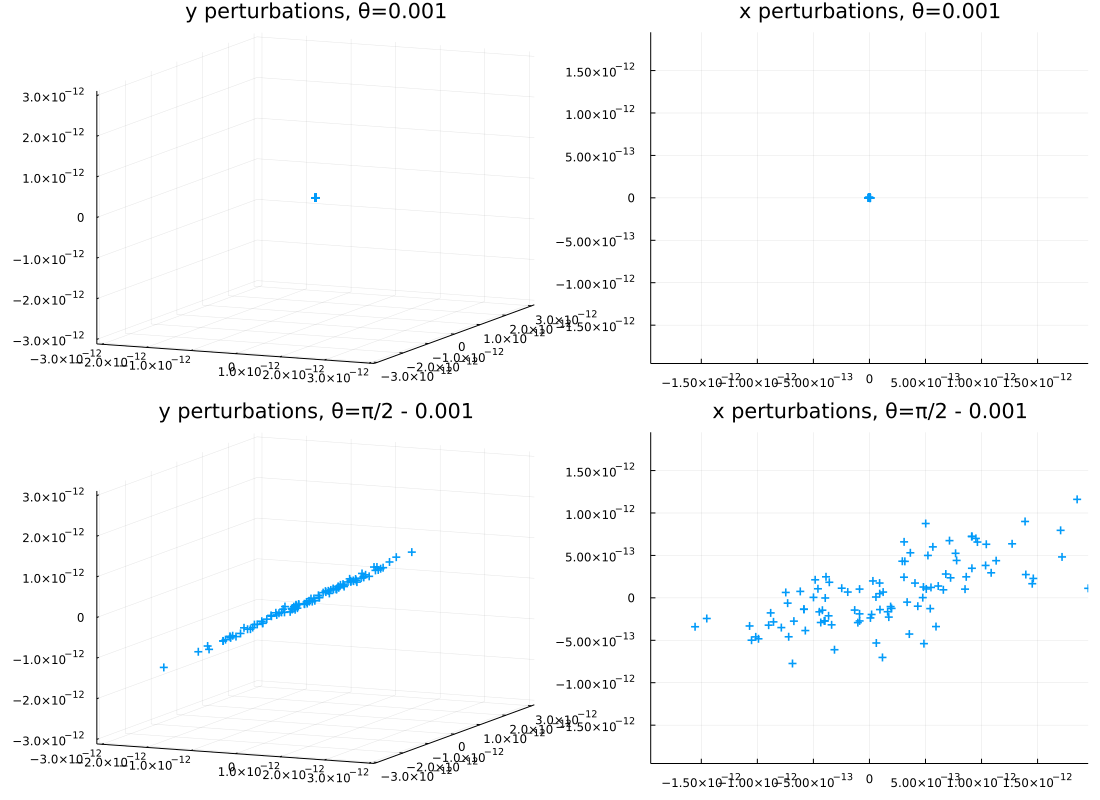

In [64]:
gr();
function generate_perturbed_least_squares(A, θ, k)
    # generate k perturbed examples
    m, n = size(A)
    x = randn(n)
    y = A * x
    Q = qr(A).Q
    q = Q[:,3]
    ŷ = y / norm(y)
    yscale = norm(y)
    b = yscale * (ŷ + q * tan(θ))
    bs = b .* (1 .+ 10 * eps() * randn(m,k))
    return (x, b, bs)
end
A = randn(3,2)
small = 0.001
x_close, b_close, bs_close = generate_perturbed_least_squares(A, small, 100)
y_close = A * x_close
xs_close = A \ bs_close
ys_close = A * xs_close
x_errs_close = (xs_close .- reshape(x_close,:,1)) ./ norm(x_close)
y_errs_close = (ys_close .- reshape(y_close,:,1)) ./ norm(y_close)

x_far, b_far, bs_far = generate_perturbed_least_squares(A, π/2 - small, 100)
y_far = A * x_far
xs_far = A \ bs_far
ys_far = A * xs_far
x_errs_far = (xs_far .- reshape(x_far,:,1)) ./ norm(x_far)
y_errs_far = (ys_far .- reshape(y_far,:,1)) ./ norm(y_far)
x_scale = maximum(abs.([x_errs_close x_errs_far]))
y_scale = maximum(abs.([y_errs_close y_errs_far]))
b_p_close = plot(y_errs_close[1,:], y_errs_close[2,:], y_errs_close[3,:], xlim=(-y_scale, y_scale), ylim=(-y_scale, y_scale), zlim=(-y_scale, y_scale), st=:scatter, m=:+, title="y perturbations, θ=$small")
x_p_close = plot(x_errs_close[1,:], x_errs_close[2,:], lim=(-x_scale, x_scale), st=:scatter, m=:+, title="x perturbations, θ=$small")
b_p_far= plot(y_errs_far[1,:], y_errs_far[2,:], y_errs_far[3,:], xlim=(-y_scale, y_scale), ylim=(-y_scale, y_scale), zlim=(-y_scale, y_scale), st=:scatter, m=:+, title="y perturbations, θ=π/2 - $small")
x_p_far = plot(x_errs_far[1,:], x_errs_far[2,:], lim=(-x_scale, x_scale), st=:scatter, m=:+, title="x perturbations, θ=π/2 - $small")
plot(b_p_close, x_p_close, b_p_far, x_p_far, layout=(2,2), size=(1100,800))

**Three non-dimensional problems govern least-squares conditioning**

1. $\kappa(A) = \frac{\sigma_1}{\sigma_m} = \|A\| \|A^+\|, \quad 1 \leq \kappa(A) < \infty$

2. $\theta = \cos^{-1} \frac{\|y\|}{\|b\|}, \quad 0 \leq \theta \leq \pi / 2$

![](./least_squares_angle.svg)

3. $\eta = \frac{\|A\| \|x\|}{\|y\|} = \frac{ \|A\| \|x\|}{\|Ax\|}, \quad 1 \leq \eta \leq \kappa(A)$

> a measure of how much $\|y\|$ falls short of its maximum possible value, given $\|A\|$ and $\|x\|$

### Can we show that $1 \leq \eta \leq \kappa(A)$?

$$\eta = \frac{\|A\| \|x\|}{\|y\|} = \frac{ \|A\| \|x\|}{\|Ax\|}$$

### Exercise

Given $2 \times 2$ matrix $\mathrm{diag}(1, \kappa^{-1})$, choose $x$ so that $\|y\| = \|A\|\|x\| / \eta$

In [85]:
κ = 1.e2
η = 50.
A = diagm([1 , 1 / κ])
x = ([[1,1] [1,1/κ^2]] \ [1,1/η^2]) .^ (1/2)
y = A * x
opnorm(A) * norm(x) / norm(y)

50.00000000000167

### Which is the "bad" end of the possibilities, $\eta = 1$ or $\eta = \kappa$? Can we measure its effects on $x$ and $y$?

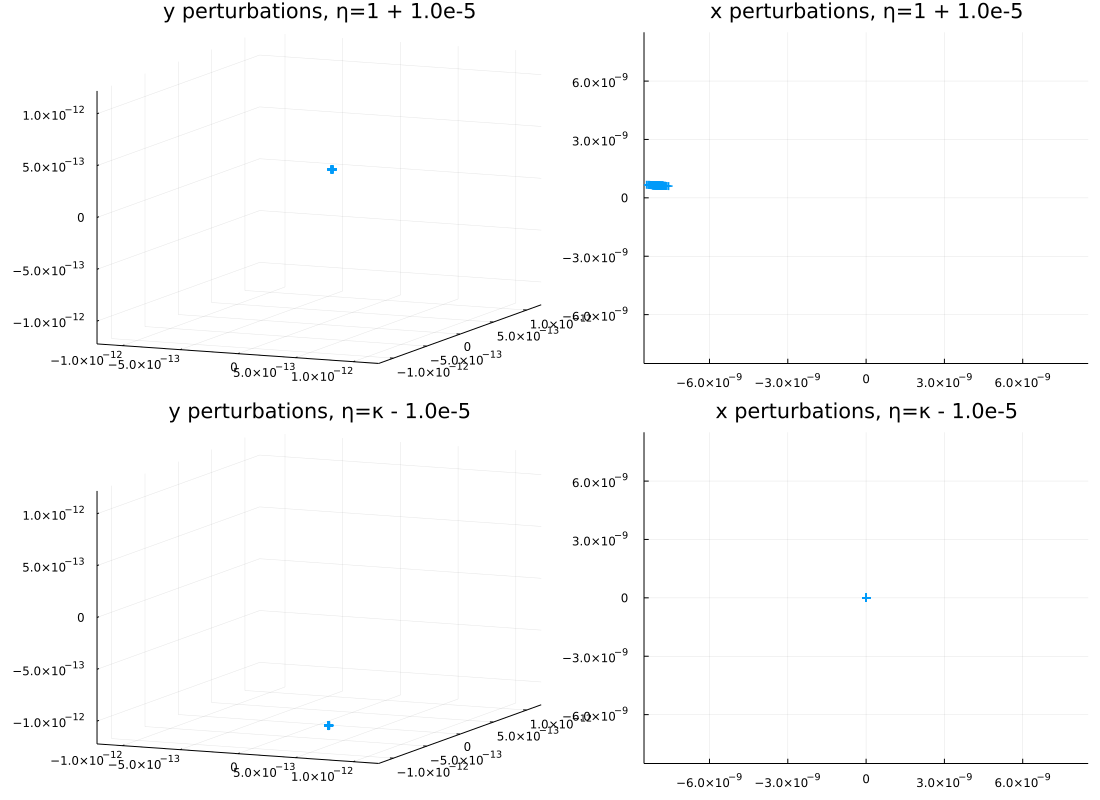

In [106]:
gr();
function generate_perturbed_least_squares_eta(A, η, k)
    # generate k perturbed examples
    m, n = size(A)
    U, σ, V = svd(A)
    κ = σ[1] / σ[n]
    x̃ = ([[1,1] [1,1/κ^2]] \ [1,1/η^2]) .^ (1/2)
    x = V[:,[1,n]] * x̃
    y = A * x
    Q = qr(A).Q
    q = Q[:,3]
    ŷ = y / norm(y)
    yscale = norm(y)
    θ = π / 4
    b = yscale * (ŷ + q * tan(θ))
    bs = b .* (1 .+ 10 * eps() * randn(m,k))
    return (x, b, bs)
end
κ = 1.e5
U = qr(randn(3,3)).Q[:,1:2]
σ = [1, 1 / κ]
V = qr(randn(2,2)).Q
A = U * diagm(σ) * V'
small = 1.e-5
x_close, b_close, bs_close = generate_perturbed_least_squares_eta(A, 1. + small, 100)
y_close = A * pinv(A) * b_close
xs_close = A \ bs_close
ys_close = A * pinv(A) * bs_close
x_errs_close = (xs_close .- reshape(x_close,:,1)) ./ norm(x_close)
y_errs_close = (ys_close .- reshape(y_close,:,1)) ./ norm(y_close)

x_far, b_far, bs_far = generate_perturbed_least_squares_eta(A, κ - small, 100)
y_far = A * pinv(A) * b_far
xs_far = A \ bs_far
ys_far = A * pinv(A) * bs_far
x_errs_far = (xs_far .- reshape(x_far,:,1)) ./ norm(x_far)
y_errs_far = (ys_far .- reshape(y_far,:,1)) ./ norm(y_far)
x_scale = maximum(abs.([x_errs_close x_errs_far]))
y_scale = maximum(abs.([y_errs_close y_errs_far]))
b_p_close = plot(y_errs_close[1,:], y_errs_close[2,:], y_errs_close[3,:], xlim=(-y_scale, y_scale), ylim=(-y_scale, y_scale), zlim=(-y_scale, y_scale), st=:scatter, m=:+, title="y perturbations, η=1 + $small")
x_p_close = plot(x_errs_close[1,:], x_errs_close[2,:], lim=(-x_scale, x_scale), st=:scatter, m=:+, title="x perturbations, η=1 + $small")
b_p_far= plot(y_errs_far[1,:], y_errs_far[2,:], y_errs_far[3,:], xlim=(-y_scale, y_scale), ylim=(-y_scale, y_scale), zlim=(-y_scale, y_scale), st=:scatter, m=:+, title="y perturbations, η=κ - $small")
x_p_far = plot(x_errs_far[1,:], x_errs_far[2,:], lim=(-x_scale, x_scale), st=:scatter, m=:+, title="x perturbations, η=κ - $small")
plot(b_p_close, x_p_close, b_p_far, x_p_far, layout=(2,2), size=(1100,800))

### T&B Theorem 18.1

Let $b \in \mathbb{C}^m$ and $A \in \mathbb{C}^{m \times n}$ of full rank be fixed.  The least squares problem
has the following 2-norm condition numbers describing the sensitivities of $y$ and $x$ to perturbations in $b$ and $A$:

| ${}$ | $y$ | $x$ |
| :-:  | :-: | :-: |
| $b$  | $\frac{1}{\cos\theta}$ | $\frac{\kappa(A)}{\eta \cos\theta}$ |
| $A$  | $\frac{\kappa(A)}{\cos\theta}$ | $\kappa(A) + \frac{\kappa(A)^2 \tan \theta}{\eta}$ |

The results in the first row are exact, being attained for certain perturbations $\delta b$, and the results in the secod row are upper bounds.

**T&B Exercise 18.4.** explain why the condition number of $y$ with respect to perturbations in $A$ is $0$ when $m = n$.

### Transformation to a diagonal basis

Let $A$ have a full SVD

$$A = U \Sigma V^*$$

- Perturbations are measured in the 2-norm: the perturbation behavior of $A$ is the same as that of $\Sigma$.

- Without loss of generality, assume $A = \Sigma$,

$$
A =
\begin{bmatrix}
\sigma_1 & & &  \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\\
\\
\end{bmatrix}
= \begin{bmatrix}A_1 \\ 0 \end{bmatrix}.
$$

- The projection of $b$ onto $\mathrm{range}(A)$ is

$$y = Pb = \begin{bmatrix} b_1 \\ 0 \end{bmatrix}.$$

- Therefore

$$x = A_1^{-1} b_1, \quad A^+ = \begin{bmatrix} A_1^{-1} & 0 \end{bmatrix}, \quad P = \begin{bmatrix} I & 0 \\ 0 & 0 \end{bmatrix}.$$

## Sensitivity of $y$ to Perturbations in $b$

From $y = Pb$, the Jacobian of $b \mapsto y$ is $P$ so

$$
\kappa_{b \mapsto y} = \frac{ \|J(x)\| }{ \| f(x) \|  / \|x\| } = \frac{\|P\|}{ \|y\| / \|b \|}.
$$

From $P$ being an orthogonal projection $\|P\| = 1$, so

$$
\kappa_{b \mapsto y} = \frac{\|b\|}{\|y\|} = \frac{1}{\cos \theta}.
$$

## Sensitivity of $x$ to Perturbations in $b$

$x = A^+ b$, so by the same reasoning

$$
\kappa_{b \mapsto x} = \frac{\|A^+\|}{\|x\| / \|b\|} = \frac{\|A^+\| \|b\|}{\|x\|} = \|A^+\| \frac{\|b\|}{\|x\|}.
$$

Multiply and divide by $\|y\|$ and use the definition of $\eta = \frac{\|A\|\|x\|}{\|y\|}$,

$$
\kappa_{b \mapsto x} = \|A^+\| \frac{\|b\|}{\|y\|} \frac{\|Ax\|}{\|x\|} = \|A^+\| \frac{1}{\cos\theta} \frac{\|A\|}{\eta}\frac{\|x\|}{\|x\|} = \frac{\kappa(A)}{\eta \cos \theta}.
$$

## Geometric understanding of $A$ perturbations

### Two types of perturbations of $A$

**Affecting the embedding of $\mathbb{C}^n$ in $\mathrm{range}(A)$**

**Affecting the location of $\mathrm{range}(A)$**

In [107]:
plotlyjs();
A = randn(3,2); b = randn(3)
p = plot_ls_diagram(A, b)
y = A*(A \ b)
scale = maximum(abs.([b y]))
plot!(p, size=(500,500))
θ = 0.2
Ã = A * [[cos(θ), sin(θ)] [-sin(θ), cos(θ)]]
ã₁ = Ã[:,1]
a1max = maximum(abs.(ã₁))
ã₁ .*= 1.1 * scale / a1max
ã₂ = Ã[:,2]
a2max = maximum(abs.(ã₂))
ã₂ .*= 1.1 * scale / a2max
plot!(p,[-ã₁[1], ã₁[1]]
    , [-ã₁[2], ã₁[2]]
    , [-ã₁[3], ã₁[3]]
    , l=5
    , c=7
    , label="a₁ + δa₁"
    )
plot!(p,[-ã₂[1], ã₂[1]]
    , [-ã₂[2], ã₂[2]]
    , [-ã₂[3], ã₂[3]]
    , l=5
    , c=7
    , label="a₂ + δa₂"
    )

In [108]:
p = plot_ls_diagram(A, b)
v = A * randn(2)
v̄ = 0.1 * v / norm(v)
Ã = [A[:,1]+(v̄ × A[:,1]) A[:,2]+(v̄ × A[:,2])]
corners = Float64[[-1,-1,-1] [ 1,-1,-1] [-1, 1,-1] [ 1, 1,-1] [-1,-1, 1] [ 1,-1, 1] [-1, 1, 1] [ 1, 1, 1]];
cycle = [1, 2, 4, 3, 7, 8, 6, 5, 1]
cube = polyhedron(vrep(corners'), lib)
triangle = [[2.0, 0.0] [-1.0, sqrt(3.)] [-1.0, -sqrt(3)]]*4
Q, _ = qr(Ã, ColumnNorm())
plot!(p, size=(500,500))
Qtrivert = Q[:,1:2]*triangle
Qtri = polyhedron(vrep((Q[:,1:2]*triangle)'), lib)
isect = hcat(points(vrep(intersect(cube, Qtri)))...)*scale
plot!(p,isect[1,:],isect[2,:],isect[3,:],st=:mesh3d
    , l = 0
    , fillalpha=0.5
    , label="range(A+δA)"
    )

### Where are perturbations that affect $\mathrm{range}(A)$?

$$
A =
\begin{bmatrix}
\sigma_1 & & &  \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\
\\
\\
\\
\end{bmatrix}
= \begin{bmatrix}A_1 \\ 0 \end{bmatrix}.
$$

$$
A =
\begin{bmatrix}
\sigma_1 & & &  \\
& \sigma_2 & & \\
& & \ddots & \\
& & & \sigma_n \\ \hline
\delta a_{(n+1),1} & \dots & & \delta a_{(n+1),n} \\
\vdots & & & \vdots \\
\delta a_{m1} & \dots & & \delta a_{mn}
\end{bmatrix}
= \begin{bmatrix}A_1 \\ \delta A_2 \end{bmatrix}.
$$

## Can simplify to one row: which row makes the biggest _angle_ change in $\mathrm{range}(A)$?

![](./angle_perturbation.svg) 

![](./angle_perturbation2.svg) 

### measuring that angle


$$ \delta\alpha = \tan^{-1} \frac{\|\delta a_n\|}{\|\sigma_n u_n\|} = \tan^{-1} \frac{\|\delta a_n\|}{\sigma_n}$$ 

Therefore

$$
|\delta\alpha| \leq |\tan \delta\alpha| = \frac{\|\delta a_n\|}{\sigma_n} \leq \frac{\|\delta A\|}{\sigma_n} =
\frac{\|\delta A\|}{\|A\|} \kappa(A).
$$

We will use this angle to bound sensitivities of $x$ and $y$ with respect to $A$

### Geometric observation: $y$ is on a sphere independent of $A$

- Centered at $b / 2$ with radius $\|b\|/2$

In [109]:
b = randn(3); midpoint = b ./ 2; radius = norm(midpoint);

In [110]:
A = randn(3,2);
p = plot_ls_diagram(A,b);

N = 128
θ = LinRange(0,2π,N)
ϕ = LinRange(-π/2,π/2,div(N,2))

x = midpoint[1] .+ radius * cos.(θ) * cos.(ϕ)'
y = midpoint[2] .+ radius * sin.(θ) * cos.(ϕ)'
z = midpoint[3] .+ radius * ones(length(θ)) * sin.(ϕ)'
surface!(p,x,y,z,c=10, fillalpha=0.5, colorbar = false)

### Perturbation $\delta \alpha$ in angle $\theta$

Creates a perturbation in $y$ of

$$\|\delta y\| = \|b\| \sin(\delta \alpha)$$

[Whiteboard]

Note that for small angles

$$\sin(\delta\alpha) = \delta \alpha - O(\delta \alpha^2)$$

so

$$\sin(\delta\alpha) < \delta \alpha$$

### Applying the $\delta \alpha$ bound

$$
\|\delta y\| \leq \|b\| \sin(\delta \alpha) \leq \|b\| \delta \alpha \leq \|b\| \frac{\|\delta A\|}{\|A\|} \kappa(A) = \frac{\|y\|}{\cos \theta} \frac{\|\delta A\|}{\|A\|} \kappa(A)
$$

Therefore

$$
\underbrace{\frac{\|\delta y\| / \|y\|}{\|\delta A\| / \|A\|}}_{\kappa_{A \mapsto y}} \leq \frac{\kappa(A)}{\cos \theta}
$$

### Sensitivity of $x$ to Perturbations in $A$

Split the perturbation $\delta A$,

$$
\delta A = \begin{bmatrix} \delta A_1 \\ 0 \end{bmatrix} + \begin{bmatrix} 0 \\ \delta A_2 \end{bmatrix}
$$

- $\delta A_1$: embedding of $\mathbb{C}^n$ into $\mathrm{range}(A)$

- $\delta A_2$: angle of $\mathrm{range}(A)$

### Perturbation $\delta A_1$ acts like a perturbation in solving a linear system of equations:

From

$$
x = A_1^{-1} b_1.
$$

So the sensitivity of $x$ with respect to $A_1$ is

$$
\frac{\|\delta x_1\| / \|x\|}{\|\delta A_1\| / \|A\|}= \kappa(A_1) = \kappa(A).
$$

### Perturbation $\delta A_2$ effectively changes $b_1$, $A_1$ stays the same

With $A_1$ remaining unchanged, the perturbed $x$ solves

$$A_1(x + \delta x) = b_1 + \delta b_1.$$

Again the condition number of $A$ is used, but we also use the argument $\eta$ to refine the estimate

$$
\frac{\|\delta x_2\| / \|x\|}{\|\delta b_1\| / \|b_1\|} = \frac{\kappa(A)}{\eta}
$$

### What is $\delta b_1$?

It is $y$ expressed in the coordinates of $\mathrm{range}(A)$.

- The only changes in $y$ that affect $\delta b_1$ are the ones in the plane of $\mathrm{range}(A)$
- A perturbation $\delta \alpha$ leads to $\delta y$ that is oblique to the plane with angle $\frac{\pi}{2} - \theta$

[whiteboard]

Therefore

$$\|\delta b_1 \| = \sin \theta \|\delta y\| \leq \|b\| \delta \alpha \sin \theta \quad \Rightarrow \quad
\frac{\|\delta b_1\|}{\|b\|} \leq \delta \alpha \sin \theta.
$$

$$
\frac{\|\delta b_1\|}{\|b\|} \leq \delta \alpha \sin \theta.
$$

But what is $\|b_1\|$? (the portion of $b$ in $\mathrm{range}(A)$)

- $\|b_1\| = \cos \theta \|b\|$, so

$$
\frac{\|\delta b_1\|}{\|b_1\|} \leq \delta \alpha \tan \theta \leq \frac{\|\delta A\|}{\|A\|} \kappa(A) \tan \theta.
$$

- final steps:

$$
\frac{\|\delta x\| / \|x\|}{\|\delta A_2\| / \|A\|}
= 
\frac{\|\delta x\| / \|x\|}{\|\delta b_1\| / \|b_1\|}
\frac{\|\delta b_1\| / \|b_1\|}{\|\delta A_2\| / \|A\|}
\leq \frac{\kappa(A)}{\eta} (\kappa(A) \tan \theta) = \frac{\kappa(A)^2}{\eta}\tan \theta.
$$